In [118]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


In [119]:
train_annotation_file = 'task1/train_data/annotations.csv'
train_img_labeled_dir = 'images/labeled/'
train_img_unlabeled_dir = 'task1/train_data/images/unlabeled/'

val_img_dir = 'task1/val_data/'

In [120]:
df = pd.read_csv(train_annotation_file)

In [121]:
df.head()

,sample,label
0,task1/train_data/images/labeled/0.jpeg,0
1,task1/train_data/images/labeled/1.jpeg,1
2,task1/train_data/images/labeled/2.jpeg,2
3,task1/train_data/images/labeled/3.jpeg,3
4,task1/train_data/images/labeled/4.jpeg,4


In [122]:
print("Number of rows in the training dataset: ",df.shape[0])
print("Number of classes: ", df['label'].nunique())
print("Percentage of each class in the training dataset:\n\n",df['label'].value_counts()*100/df.shape[0])

Number of rows in the training dataset:  23555
Number of classes:  100
Percentage of each class in the training dataset:

 label
52    1.226916
5     1.226916
3     1.214180
8     1.188707
82    1.188707
        ...   
83    0.721715
75    0.708979
92    0.662280
89    0.632562
96    0.318404
Name: count, Length: 100, dtype: float64


In [123]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [124]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15), 
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    
])

In [125]:
class AAITDataset(Dataset):
    def __init__(self, dataset, img_dir, is_train=True, transform=None, target_transform=None):
        self.is_train = is_train
        if self.is_train:
            self.img_labels = dataset
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.is_train:
            return len(self.img_labels)
        else:
            self.img_files = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]
            return len(self.img_files)

    def __getitem__(self, idx):
        if self.is_train:
            img_path = self.img_labels.iloc[idx, 0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            #print(image)
            if image.size()[0] == 1:
                image = image.expand(3, -1, -1)
            label = self.img_labels.iloc[idx, 1]
            
            if self.target_transform:
                label = self.target_transform(label)
            return image, label, img_path
        else: 
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            if image.size(0) == 1:
                image = image.expand(3, -1, -1)
            
            return image, img_path

In [126]:
train_dataset = AAITDataset(train_data, train_img_labeled_dir, is_train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = AAITDataset(test_data, train_img_labeled_dir, is_train=True, transform=transform)
test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

train_unlabeled_dataset = AAITDataset(None, train_img_unlabeled_dir, is_train=False, transform=transform)
train_unlabeled_dataloader = DataLoader(train_unlabeled_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


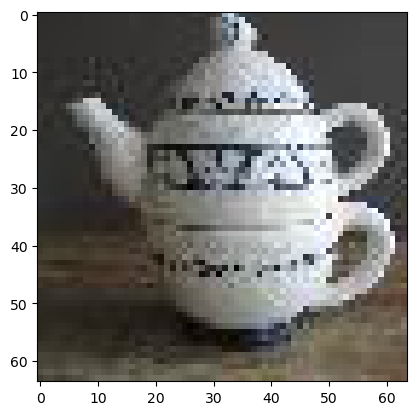

Label: 45


In [127]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 64, 64])


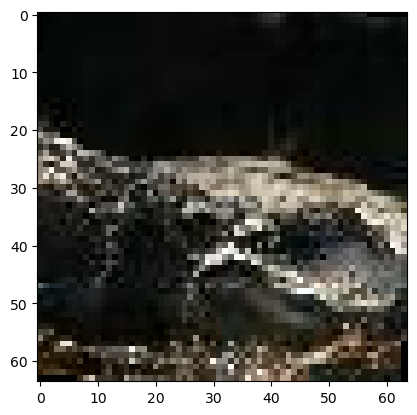

In [103]:
train_features, _ = next(iter(train_unlabeled_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

In [128]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print(mps_device)
else:
    print("MPS not found!")

mps


In [105]:
%%time
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CustomModel, self).__init__()
        
        self.resnet50 = models.resnet50(weights="IMAGENET1K_V2") # pretrained = True

        num_features = self.resnet50.fc.in_features
        self.dropout = nn.Dropout(p=0.1)
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, num_classes)
        )
        #self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        
        return self.resnet50(x)


teacher_model = CustomModel(num_classes=100, pretrained=True).to(mps_device)
student_model = CustomModel(num_classes=100, pretrained=True).to(mps_device)

def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels, _ in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
train_model(teacher_model, train_dataloader, criterion, optimizer, epochs=30, device=mps_device)
avg_loss, acc, prec, rec, f1 = evaluate_model(teacher_model, test_dataloader, criterion, mps_device)
print("Results:")
print("Average loss: ", avg_loss)
print("Accuracy: ", acc*100)
print("Precision: ", prec*100)
print("Recall: ", rec*100)
print("F1 score: ", f1*100)

100%|██████████| 295/295 [00:23<00:00, 12.42it/s]


Epoch 1/30, Loss: 4.4871, Accuracy: 9.38%


100%|██████████| 295/295 [00:21<00:00, 13.56it/s]


Epoch 2/30, Loss: 3.3529, Accuracy: 35.39%


100%|██████████| 295/295 [00:21<00:00, 13.79it/s]


Epoch 3/30, Loss: 1.9942, Accuracy: 53.07%


100%|██████████| 295/295 [00:21<00:00, 13.72it/s]


Epoch 4/30, Loss: 1.5086, Accuracy: 61.85%


100%|██████████| 295/295 [00:21<00:00, 13.53it/s]


Epoch 5/30, Loss: 1.2732, Accuracy: 67.08%


100%|██████████| 295/295 [00:21<00:00, 13.56it/s]


Epoch 6/30, Loss: 1.1117, Accuracy: 70.23%


100%|██████████| 295/295 [00:21<00:00, 13.53it/s]


Epoch 7/30, Loss: 0.9863, Accuracy: 73.26%


100%|██████████| 295/295 [00:21<00:00, 13.49it/s]


Epoch 8/30, Loss: 0.8900, Accuracy: 76.01%


100%|██████████| 295/295 [00:21<00:00, 13.54it/s]


Epoch 9/30, Loss: 0.7973, Accuracy: 77.97%


100%|██████████| 295/295 [00:21<00:00, 13.54it/s]


Epoch 10/30, Loss: 0.7184, Accuracy: 80.39%


100%|██████████| 295/295 [00:21<00:00, 13.53it/s]


Epoch 11/30, Loss: 0.6556, Accuracy: 81.65%


100%|██████████| 295/295 [00:21<00:00, 13.56it/s]


Epoch 12/30, Loss: 0.5905, Accuracy: 83.71%


100%|██████████| 295/295 [00:21<00:00, 13.56it/s]


Epoch 13/30, Loss: 0.5331, Accuracy: 85.06%


100%|██████████| 295/295 [00:21<00:00, 13.55it/s]


Epoch 14/30, Loss: 0.4896, Accuracy: 86.22%


100%|██████████| 295/295 [00:21<00:00, 13.55it/s]


Epoch 15/30, Loss: 0.4398, Accuracy: 87.53%


100%|██████████| 295/295 [00:21<00:00, 13.53it/s]


Epoch 16/30, Loss: 0.3989, Accuracy: 88.61%


100%|██████████| 295/295 [00:21<00:00, 13.55it/s]


Epoch 17/30, Loss: 0.3516, Accuracy: 90.12%


100%|██████████| 295/295 [00:21<00:00, 13.54it/s]


Epoch 18/30, Loss: 0.3229, Accuracy: 91.06%


100%|██████████| 295/295 [00:21<00:00, 13.51it/s]


Epoch 19/30, Loss: 0.2999, Accuracy: 91.64%


100%|██████████| 295/295 [00:21<00:00, 13.50it/s]


Epoch 20/30, Loss: 0.2628, Accuracy: 92.60%


100%|██████████| 295/295 [00:21<00:00, 13.53it/s]


Epoch 21/30, Loss: 0.2502, Accuracy: 92.95%


100%|██████████| 295/295 [00:21<00:00, 13.52it/s]


Epoch 22/30, Loss: 0.2175, Accuracy: 93.88%


100%|██████████| 295/295 [00:21<00:00, 13.56it/s]


Epoch 23/30, Loss: 0.2009, Accuracy: 94.37%


100%|██████████| 295/295 [00:21<00:00, 13.50it/s]


Epoch 24/30, Loss: 0.1849, Accuracy: 94.76%


100%|██████████| 295/295 [00:22<00:00, 13.25it/s]


Epoch 25/30, Loss: 0.1685, Accuracy: 95.25%


100%|██████████| 295/295 [00:22<00:00, 13.19it/s]


Epoch 26/30, Loss: 0.1543, Accuracy: 95.59%


100%|██████████| 295/295 [00:22<00:00, 13.06it/s]


Epoch 27/30, Loss: 0.1422, Accuracy: 96.09%


100%|██████████| 295/295 [00:22<00:00, 12.93it/s]


Epoch 28/30, Loss: 0.1291, Accuracy: 96.46%


100%|██████████| 295/295 [00:23<00:00, 12.79it/s]


Epoch 29/30, Loss: 0.1156, Accuracy: 96.81%


100%|██████████| 295/295 [00:23<00:00, 12.68it/s]


Epoch 30/30, Loss: 0.1113, Accuracy: 96.91%
Results:
Average loss:  0.04182882203673154
Accuracy:  99.1562300997665
Precision:  99.16724366286151
Recall:  99.1562300997665
F1 score:  99.15690622788401
CPU times: user 9min 59s, sys: 1min 13s, total: 11min 13s
Wall time: 11min 10s


In [106]:
def generate_pseudo_labels(model, dataloader):
    model.eval()
    pseudo_label_data = []
    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(mps_device)
            outputs = model(images)
            probs, predicted = torch.max(outputs, 1)
            
            
            for img_path, label in zip(img_paths, predicted):
                pseudo_label_data.append((img_path, label.item()))

    pseudo_labels_df = pd.DataFrame(pseudo_label_data, columns=['sample', 'label'])
    return pseudo_labels_df


pseudo_labels = generate_pseudo_labels(teacher_model, train_unlabeled_dataloader)


In [107]:
pseudo_labels.to_csv('task1/train_data/annotations_pseudo.csv', index=False)

In [108]:
from torch.utils.data import ConcatDataset

train_dataset = AAITDataset(df, train_img_labeled_dir, is_train=True, transform=transform)
#train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

train_annotation_file_un = 'task1/train_data/annotations_pseudo.csv'
train_img_unlabeled_dir = 'images/unlabeled/'

train_dataset_un = AAITDataset(pseudo_labels, train_img_unlabeled_dir, is_train=True, transform=transform)
#train_dataloader_un = DataLoader(train_dataset_un, batch_size=64, shuffle=True)

combined_dataset = ConcatDataset([train_dataset, train_dataset_un])
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)


In [109]:
#optimizer = torch.optim.Adam(student_model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)
train_model(student_model, combined_dataloader, criterion, optimizer, epochs=20, device=mps_device)


100%|██████████| 782/782 [01:03<00:00, 12.24it/s]


Epoch 1/30, Loss: 3.3545, Accuracy: 31.11%


100%|██████████| 782/782 [01:02<00:00, 12.44it/s]


Epoch 2/30, Loss: 1.4383, Accuracy: 62.68%


100%|██████████| 782/782 [01:05<00:00, 11.89it/s]


Epoch 3/30, Loss: 1.1074, Accuracy: 69.92%


100%|██████████| 782/782 [01:09<00:00, 11.33it/s]


Epoch 4/30, Loss: 0.9488, Accuracy: 73.72%


100%|██████████| 782/782 [01:09<00:00, 11.17it/s]


Epoch 5/30, Loss: 0.8349, Accuracy: 76.63%


100%|██████████| 782/782 [01:09<00:00, 11.26it/s]


Epoch 6/30, Loss: 0.7348, Accuracy: 79.17%


100%|██████████| 782/782 [01:07<00:00, 11.51it/s]


Epoch 7/30, Loss: 0.6527, Accuracy: 81.41%


100%|██████████| 782/782 [01:06<00:00, 11.76it/s]


Epoch 8/30, Loss: 0.5847, Accuracy: 83.13%


100%|██████████| 782/782 [01:04<00:00, 12.04it/s]


Epoch 9/30, Loss: 0.5198, Accuracy: 85.00%


100%|██████████| 782/782 [01:03<00:00, 12.25it/s]


Epoch 10/30, Loss: 0.4599, Accuracy: 86.57%


100%|██████████| 782/782 [01:03<00:00, 12.37it/s]


Epoch 11/30, Loss: 0.4104, Accuracy: 87.83%


100%|██████████| 782/782 [01:02<00:00, 12.43it/s]


Epoch 12/30, Loss: 0.3707, Accuracy: 89.13%


100%|██████████| 782/782 [01:02<00:00, 12.42it/s]


Epoch 13/30, Loss: 0.3246, Accuracy: 90.55%


100%|██████████| 782/782 [01:02<00:00, 12.41it/s]


Epoch 14/30, Loss: 0.2872, Accuracy: 91.43%


100%|██████████| 782/782 [01:03<00:00, 12.32it/s]


Epoch 15/30, Loss: 0.2570, Accuracy: 92.29%


100%|██████████| 782/782 [01:03<00:00, 12.34it/s]


Epoch 16/30, Loss: 0.2321, Accuracy: 93.13%


100%|██████████| 782/782 [01:03<00:00, 12.29it/s]


Epoch 17/30, Loss: 0.2088, Accuracy: 93.76%


100%|██████████| 782/782 [01:03<00:00, 12.23it/s]


Epoch 18/30, Loss: 0.1867, Accuracy: 94.53%


100%|██████████| 782/782 [01:04<00:00, 12.20it/s]


Epoch 19/30, Loss: 0.1732, Accuracy: 94.84%


100%|██████████| 782/782 [01:04<00:00, 12.19it/s]


Epoch 20/30, Loss: 0.1592, Accuracy: 95.26%


100%|██████████| 782/782 [01:05<00:00, 12.00it/s]


Epoch 21/30, Loss: 0.1421, Accuracy: 95.74%


100%|██████████| 782/782 [01:05<00:00, 11.97it/s]


Epoch 22/30, Loss: 0.1290, Accuracy: 96.14%


100%|██████████| 782/782 [01:05<00:00, 11.85it/s]


Epoch 23/30, Loss: 0.1197, Accuracy: 96.32%


100%|██████████| 782/782 [01:06<00:00, 11.76it/s]


Epoch 24/30, Loss: 0.1118, Accuracy: 96.64%


100%|██████████| 782/782 [01:06<00:00, 11.81it/s]


Epoch 25/30, Loss: 0.1052, Accuracy: 96.93%


100%|██████████| 782/782 [01:05<00:00, 12.00it/s]


Epoch 26/30, Loss: 0.0956, Accuracy: 97.24%


100%|██████████| 782/782 [01:06<00:00, 11.78it/s]


Epoch 27/30, Loss: 0.0872, Accuracy: 97.39%


100%|██████████| 782/782 [01:05<00:00, 11.93it/s]


Epoch 28/30, Loss: 0.0832, Accuracy: 97.57%


100%|██████████| 782/782 [01:04<00:00, 12.09it/s]


Epoch 29/30, Loss: 0.0771, Accuracy: 97.66%


100%|██████████| 782/782 [01:01<00:00, 12.77it/s]

Epoch 30/30, Loss: 0.0704, Accuracy: 97.91%


In [112]:
val_unlabeled_dataset = AAITDataset(None, val_img_dir, is_train=False, transform=transform2)
val_unlabeled_dataloader = DataLoader(val_unlabeled_dataset, batch_size=64, shuffle=False)

val_labels = generate_pseudo_labels(student_model, val_unlabeled_dataloader)
val_labels['sample'] = val_labels['sample'].apply(lambda x: x.split('/')[-1])


In [113]:
val_labels['sort_key'] = val_labels['sample'].str.extract('(\d+)').astype(int)
val_labels.sort_values(by='sort_key', ascending=True, inplace=True)
val_labels.reset_index(inplace=True)
val_labels.drop(columns=['sort_key','index'], inplace=True)

val_labels.to_csv('task1/simple_pseudo_labels.csv', index=False)